In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
seqpath='/Users/andrew/Desktop/snfsearch5/'
inseqfile='hmmSnf2-E-120-trim.fa'
inseqfile='hmmSnf2-E-120-trim-filt-mafft.fa'
inseqfile='hmmSnf2-E-120-trim-filt-muscle.fa'
#inseqfile='hmmSnf2-E-75-trim.fa'
#inseqfile='hmmSnf2-E-75-trim-filt-mafft.fa'
outfilestem=inseqfile[:inseqfile.rfind('.')]
outseqfile='{}-filt.fa'.format(outfilestem)

In [3]:
#Read in fasta file
seqs={}
fi=open(seqpath+inseqfile,'r')
while 1:
    d=fi.readline()
    if not d:
        break
    elif d[0]=='>':
        header=d[1:].strip()
        sid=header.split(' ')[0]
        sid.replace('UniRef100_','')
        seqs[sid]={'header':header,'seq':''}
    else:
        seqs[sid]['seq']+=d.strip()
fi.close()
dfs=pd.DataFrame.from_dict(seqs,orient='index',columns=['seq','header'])
print('Starting with {} sequences'.format(dfs.shape[0]))
#dfs

Starting with 11345 sequences


In [4]:
#Dataframe of unique sequences with ID and all IDs
dfsu=pd.DataFrame([[IDs.index.to_list()[0],' '.join(IDs.index.to_list()),seq] for seq,IDs in dfs.groupby('seq')],columns=['ID','IDs','seq'])
dfsu=dfsu.set_index('ID')
print('Now have {} sequences'.format(dfsu.shape[0]))
#dfsu

Now have 11345 sequences


In [5]:
#Dataframe with unique sequences at one residue per column
#Takes 30 seconds or so
dfsuc=dfsu['seq'].apply(lambda x: pd.Series(list(x)))
dfsuc=dfsuc.replace('.',np.nan)
dfsuc=dfsuc.replace('-',np.nan)
print('Now have {} sequences of total length {} residues'.format(dfsuc.shape[0],dfsuc.shape[1]))
#Remove all rows containing X
droprows=dfsuc[(dfsuc=='X') | (dfsuc=='x')].any(axis=1)
dfsuc=dfsuc[~droprows]
print('Dropping {} rows with X in any column'.format(len(droprows.index[droprows])))
#dfsuc

Now have 11345 sequences of total length 9392 residues
Dropping 0 rows with X in any column


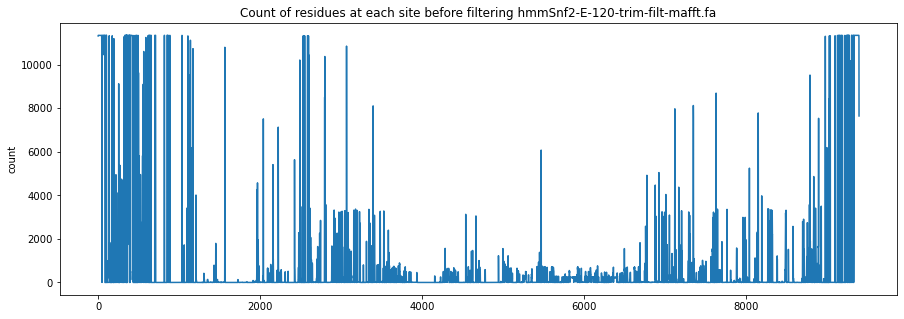

In [6]:
#Dataframe with counts of residues in each column
dfsucc=pd.DataFrame(data=dfsuc.count(axis='rows'),columns=['count'])

plt.figure(figsize=(15,5));
sns.lineplot(data=dfsucc,x=dfsucc.index,y="count")
plt.title('Count of residues at each site before filtering {}'.format(inseqfile))
#plt.ylim(0,100);
plt.savefig('{}{}-counts.png'.format(seqpath,outfilestem))

In [7]:
#Do first round of dropping rows for nearly empty columns
#Threshold rows to be considered as outliers (eg 2.5E-3 = 0.25%)
outlierfraction=5E-3

#Remove all rows with residues missing in threshold number of cases
dfsucc=pd.DataFrame(data=dfsuc.count(axis='rows'),columns=['count'])
almostallcount=len(dfsuc.index)-int(len(dfsuc.index)*outlierfraction)
watchcolumns=list(np.flatnonzero(dfsucc>almostallcount))
droprows=dfsuc[watchcolumns].isna().any(axis=1)
dfsuc2=dfsuc.drop(droprows.index[droprows])
print('Dropping {} rows with no residue in {} columns having more than {} representatives'\
      .format(len(droprows.index[droprows]),len(watchcolumns),almostallcount))

#Remove all rows with less than threshold having residues
dfsucc=pd.DataFrame(data=dfsuc.count(axis='rows'),columns=['count'])
outlierlimit=int(len(dfsuc2.index)*outlierfraction)
watchcolumns=list(np.flatnonzero(dfsucc<outlierlimit))
droprows=dfsuc2[watchcolumns].notna().any(axis=1)
dfsuc2=dfsuc2.drop(droprows.index[droprows])
print('Dropping {} rows with residues in {} columns having less than {} representatives'\
      .format(len(droprows.index[droprows]),len(watchcolumns),outlierlimit))

#Remove all columns without residues
startcolcount=len(dfsuc2.columns)
dfsuc2=dfsuc2.dropna(axis='columns',how='all')
print('Dropping {} columns with no residues'.format(startcolcount-len(dfsuc2.columns)))

#Remove all rows containing no residue in first or last column (ie not full span)
#watchcolumns=[dfsuc2.columns[0],dfsuc2.columns[-1]]
#droprows=dfsuc2[watchcolumns].isna().any(axis=1)
#dfsuc2=dfsuc2.drop(droprows.index[droprows])
#print('Dropping {} rows not encompassing full span'.format(len(droprows.index[droprows])))

#Renumber the columns to their actual sequence
dfsuc2=dfsuc2.rename(columns={x:y for x,y in zip(dfsuc2.columns,range(0,len(dfsuc2.columns)))})
print('Now have {} sequences of total length {} residues'.format(dfsuc2.shape[0],dfsuc2.shape[1]))
#dfsuc2

Dropping 363 rows with no residue in 376 columns having more than 11289 representatives
Dropping 2302 rows with residues in 6950 columns having less than 54 representatives
Dropping 7047 columns with no residues
Now have 8680 sequences of total length 2345 residues


In [8]:
#Remove all rows without 6 helicase motifs (excludes Ia)
snf2motifs={'I':'ILADEMGLGKT','II':'DEGH','III':'LTGTPLQN','IV':'LIFFQMTQ','V':'LSTRAGGLGLN','VI':'QAQDRAHR'}
if 'P22082' in dfsuc2.index:
    snf2id='P22082'
elif 'H0GNZ3' in dfsuc2.index:
    snf2id='H0GNZ3'   
else:
    snf2id=dfsu[dfsu['IDs'].str.contains('P22082')].index
snf2seq=dfsuc2.loc[snf2id].fillna('-').apply(''.join).values[0].upper()
watchcolumns=[i for s in [list(range(snf2seq.find(v),snf2seq.find(v)+len(v))) for k,v in snf2motifs.items() if snf2seq.find(v)>0] for i in s]
droprows=dfsuc2[watchcolumns].isna().any(axis=1)
dfsuc2=dfsuc2.drop(droprows.index[droprows])
print('Dropping {} rows with no residue in {} columns for helicase motifs I-VI'\
      .format(len(droprows.index[droprows]),len(watchcolumns)))

#Remove all columns without residues
startcolcount=len(dfsuc2.columns)
dfsuc2=dfsuc2.dropna(axis='columns',how='all')
print('Dropping {} columns with no residues'.format(startcolcount-len(dfsuc2.columns)))
print('Now have {} sequences of total length {} residues'.format(dfsuc2.shape[0],dfsuc2.shape[1]))

Dropping 0 rows with no residue in 0 columns for helicase motifs I-VI
Dropping 0 columns with no residues
Now have 8680 sequences of total length 2345 residues


In [9]:
#Do another round of dropping rows for nearly empty columns
#Threshold rows to be considered as outliers (eg 2.5E-3 = 0.25%)
outlierfraction=5E-3

#Remove all rows with residues missing in threshold number of cases
dfsuc2c=pd.DataFrame(data=dfsuc2.count(axis='rows'),columns=['count'])
almostallcount=len(dfsuc2.index)-int(len(dfsuc2.index)*outlierfraction)
watchcolumns=list(np.flatnonzero(dfsuc2c>almostallcount))
droprows=dfsuc2[watchcolumns].isna().any(axis=1)
dfsuc2=dfsuc2.drop(droprows.index[droprows])
print('Dropping {} rows with no residue in {} columns having more than {} representatives'\
      .format(len(droprows.index[droprows]),len(watchcolumns),almostallcount))

#Remove all rows with less than threshold having residues
dfsuc2c=pd.DataFrame(data=dfsuc2.count(axis='rows'),columns=['count'])
outlierlimit=int(len(dfsuc2.index)*outlierfraction)
watchcolumns=list(np.flatnonzero(dfsuc2c<outlierlimit))
droprows=dfsuc2[watchcolumns].notna().any(axis=1)
dfsuc2=dfsuc2.drop(droprows.index[droprows])
print('Dropping {} rows with residues in {} columns having less than {} representatives'\
      .format(len(droprows.index[droprows]),len(watchcolumns),outlierlimit))

#Remove all columns without residues
startcolcount=len(dfsuc2.columns)
dfsuc2=dfsuc2.dropna(axis='columns',how='all')
print('Dropping {} columns with no residues'.format(startcolcount-len(dfsuc2.columns)))

Dropping 36 rows with no residue in 380 columns having more than 8637 representatives
Dropping 545 rows with residues in 182 columns having less than 43 representatives
Dropping 182 columns with no residues


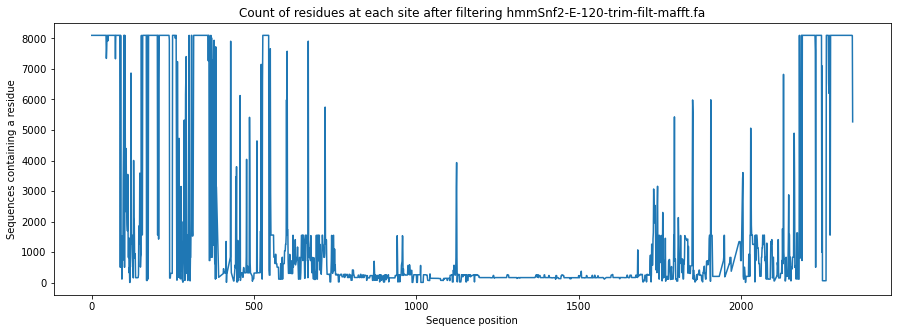

In [10]:
#Dataframe with counts of residues in each column
dfsuc2c=pd.DataFrame(data=dfsuc2.count(),columns=['count'])

plt.figure(figsize=(15,5));
sns.lineplot(data=dfsuc2c,x=dfsuc2c.index,y="count")
#plt.ylim(0,100);
plt.title('Count of residues at each site after filtering {}'.format(inseqfile))
plt.xlabel('Sequence position');
plt.ylabel('Sequences containing a residue');
plt.savefig('{}{}-filt-counts.png'.format(seqpath,outfilestem))

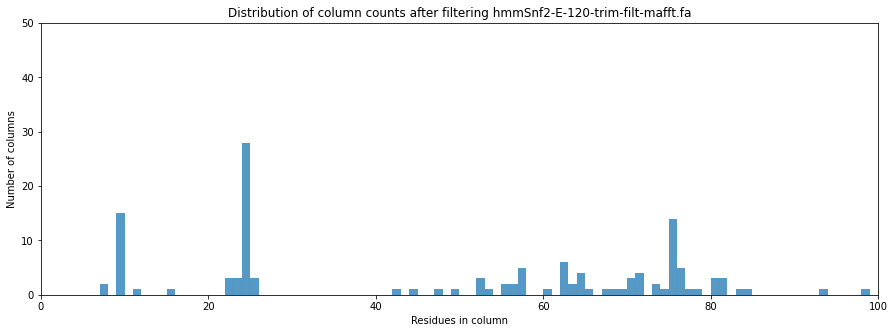

In [11]:
#Zoom in on columns with only a few cases
plt.figure(figsize=(15,5))
sns.histplot(dfsuc2c,binwidth=1,legend=False)
plt.xlim(0,100);
plt.ylim(0,50);
plt.title('Distribution of column counts after filtering {}'.format(inseqfile))
plt.xlabel('Residues in column');
plt.ylabel('Number of columns');
plt.savefig('{}{}-filt-countdist.png'.format(seqpath,outfilestem))

In [12]:
#Replace NaN with gap character then concatenate
dfsuc2=dfsuc2.fillna('-')
#Join all columns together as sequence
dfsout=dfsuc2.apply(''.join, axis=1)

In [13]:
#Prepare fasta format
outlines=''
for ID, seq in dfsout.iteritems():
    outlines+='>{}\n{}\n'.format(ID,seq)
with open(seqpath+outseqfile,'w') as outfile:
    outfile.write(outlines)
    pass
print('fasta file with {} sequences written as {}'.format(len(dfsout),outseqfile))

fasta file with 8099 sequences written as hmmSnf2-E-120-trim-filt-mafft-filt.fa
